In [1]:
pip install pandas scikit-learn nltk textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ------- -------------------------------- 112.6/626.3 kB 2.2 MB/s eta 0:00:01
   -------------- ------------------------- 225.3/626.3 kB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/626.3 kB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/626.3 kB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/626.3 kB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/626.3 kB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 256.0/626.3 kB 2.3 MB/s eta 0:00:01
   --------------------- ---------------- 358.4/626.3 kB 969.8 kB/s eta 0:00:01
   ---------------------------- ----------- 450.6/626.3 kB 1.1 MB/s eta 0:00:01
 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import string

In [3]:
# Load the dataset
df = pd.read_csv('blogs_categories.csv')

In [4]:
# Display the first few rows of the dataset
print(df.head())

   Unnamed: 0                                               Data       Labels
0           0  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...  alt.atheism
1           1  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  alt.atheism
2           2  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
3           3  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  alt.atheism
4           4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  alt.atheism


In [5]:
# Display information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19997 non-null  int64 
 1   Data        19997 non-null  object
 2   Labels      19997 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB
None


In [6]:
# Check for missing values
print(df.isnull().sum())

Unnamed: 0    0
Data          0
Labels        0
dtype: int64


alt.atheism                 1000
comp.graphics               1000
talk.politics.misc          1000
talk.politics.mideast       1000
talk.politics.guns          1000
sci.space                   1000
sci.med                     1000
sci.electronics             1000
sci.crypt                   1000
rec.sport.hockey            1000
rec.sport.baseball          1000
rec.motorcycles             1000
rec.autos                   1000
misc.forsale                1000
comp.windows.x              1000
comp.sys.mac.hardware       1000
comp.sys.ibm.pc.hardware    1000
comp.os.ms-windows.misc     1000
talk.religion.misc          1000
soc.religion.christian       997
Name: Labels, dtype: int64


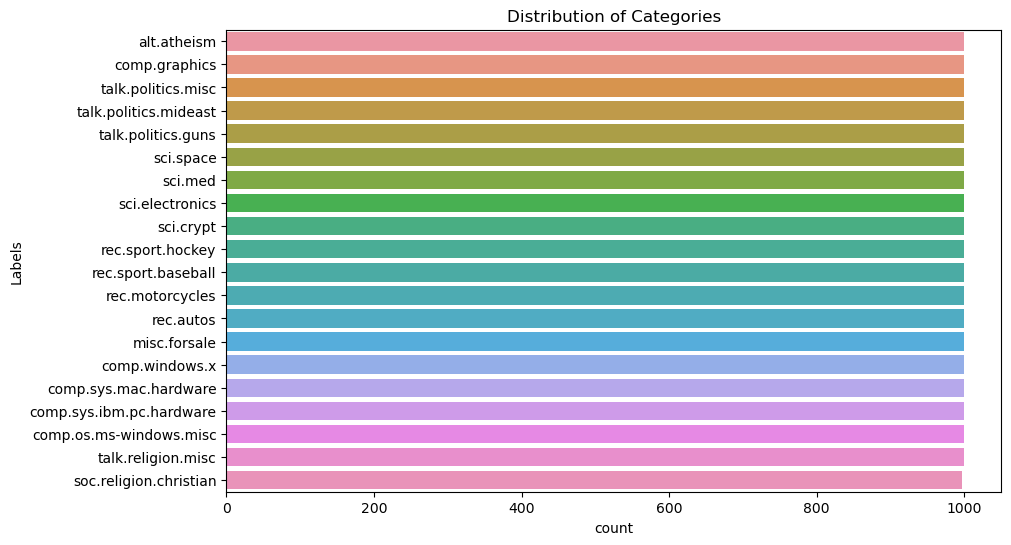

In [7]:
# Distribution of categories
print(df['Labels'].value_counts())
plt.figure(figsize=(10,6))
sns.countplot(y='Labels', data=df, order=df['Labels'].value_counts().index)
plt.title('Distribution of Categories')
plt.show()

In [8]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reshma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Reshma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Reshma\AppData\Roaming\nltk_data...


True

In [9]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:

# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return ' '.join(words)


In [11]:

# Apply the preprocessing function to the 'Data' column
df['Processed_Data'] = df['Data'].apply(preprocess_text)

# Display the first few rows of the processed data
print(df[['Data', 'Processed_Data']].head())


                                                Data  \
0  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...   
1  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...   
2  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
3  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...   
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...   

                                      Processed_Data  
0  xref cantaloupesrvcscmuedu path mathew mathewm...  
1  xref cantaloupesrvcscmuedu path mathew mathewm...  
2  newsgroups altatheism path benedikt rosenau su...  
3  xref cantaloupesrvcscmuedu path mathew mathewm...  
4  xref cantaloupesrvcscmuedu newsgroups altathei...  


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the processed text data
X = tfidf_vectorizer.fit_transform(df['Processed_Data']).toarray()

# Extract the labels
y = df['Labels']

# Display the shape of the feature matrix and label vector
print(f'Feature matrix shape: {X.shape}')
print(f'Label vector shape: {y.shape}')


Feature matrix shape: (19997, 5000)
Label vector shape: (19997,)


In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and test sets
print(f'Training feature matrix shape: {X_train.shape}')
print(f'Test feature matrix shape: {X_test.shape}')
print(f'Training label vector shape: {y_train.shape}')
print(f'Test label vector shape: {y_test.shape}')


Training feature matrix shape: (15997, 5000)
Test feature matrix shape: (4000, 5000)
Training label vector shape: (15997,)
Test label vector shape: (4000,)


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

In [15]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [16]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(classification_report(y_test, y_pred))

Accuracy: 0.87675
Precision: 0.8752635516614482
Recall: 0.87675
F1 Score: 0.8745465112284453
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.78      0.74       173
           comp.graphics       0.77      0.88      0.83       179
 comp.os.ms-windows.misc       0.87      0.86      0.86       226
comp.sys.ibm.pc.hardware       0.82      0.79      0.81       204
   comp.sys.mac.hardware       0.87      0.94      0.90       205
          comp.windows.x       0.91      0.92      0.91       186
            misc.forsale       0.86      0.86      0.86       190
               rec.autos       0.93      0.94      0.93       203
         rec.motorcycles       0.98      0.93      0.96       218
      rec.sport.baseball       0.98      0.98      0.98       192
        rec.sport.hockey       0.99      0.98      0.98       203
               sci.crypt       0.93      0.94      0.93       200
         sci.electronics       0.91      0.86   

In [17]:
from textblob import TextBlob

# Define a function to get the sentiment of a text
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [18]:
# Apply the sentiment analysis function to the 'Data' column
df['Sentiment'] = df['Data'].apply(get_sentiment)

# Display the first few rows of the dataset with sentiments
print(df[['Data', 'Sentiment']].head())

                                                Data Sentiment
0  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...  Positive
1  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  Positive
2  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  Positive
3  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  Positive
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...  Negative


In [19]:
# Analyze sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

Positive    15282
Negative     4709
Neutral         6
Name: Sentiment, dtype: int64


In [20]:
# Sentiment distribution across categories
sentiment_category_distribution = df.groupby('Labels')['Sentiment'].value_counts(normalize=True).unstack()
print(sentiment_category_distribution)

Sentiment                 Negative  Neutral  Positive
Labels                                               
alt.atheism               0.199000      NaN  0.801000
comp.graphics             0.250000    0.001  0.749000
comp.os.ms-windows.misc   0.236000      NaN  0.764000
comp.sys.ibm.pc.hardware  0.238000    0.001  0.761000
comp.sys.mac.hardware     0.242000      NaN  0.758000
comp.windows.x            0.290000    0.002  0.708000
misc.forsale              0.229000      NaN  0.771000
rec.autos                 0.201000      NaN  0.799000
rec.motorcycles           0.262000      NaN  0.738000
rec.sport.baseball        0.249000      NaN  0.751000
rec.sport.hockey          0.297000      NaN  0.703000
sci.crypt                 0.209000      NaN  0.791000
sci.electronics           0.211000      NaN  0.789000
sci.med                   0.219000      NaN  0.781000
sci.space                 0.235000    0.001  0.764000
soc.religion.christian    0.171515      NaN  0.828485
talk.politics.guns        0.

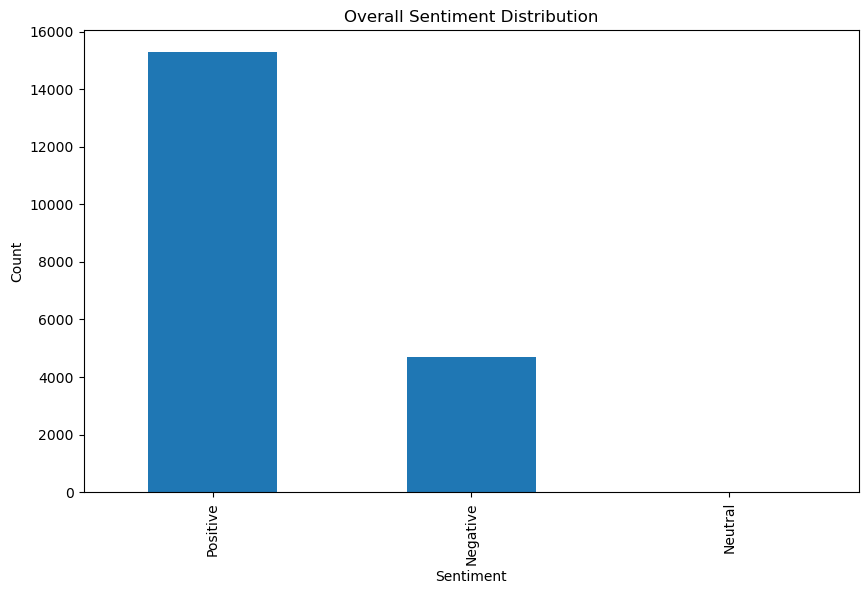

In [21]:
# Plot the sentiment distribution
plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='bar')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

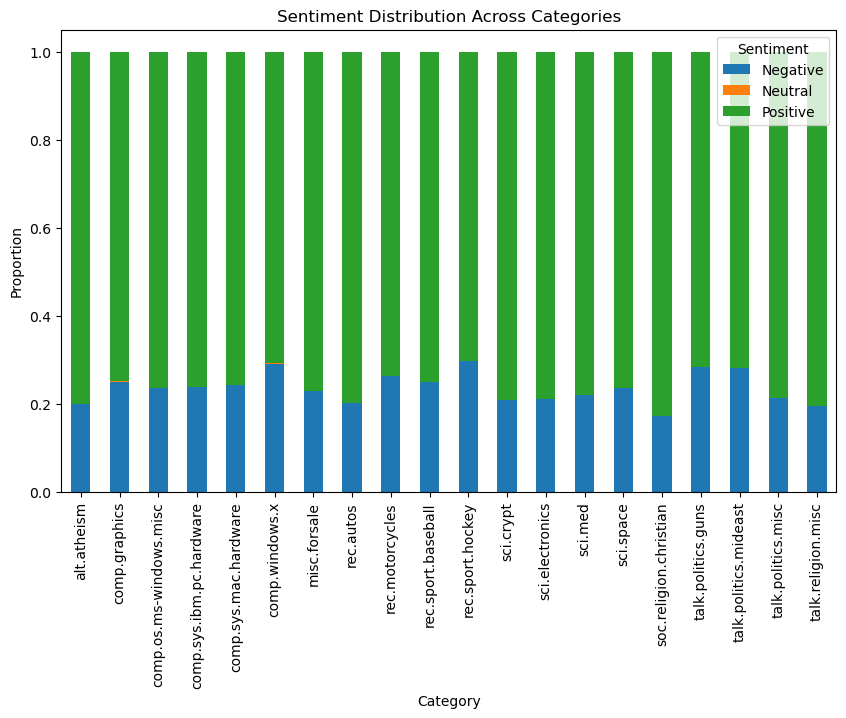

In [22]:
# Plot the sentiment distribution across categories
sentiment_category_distribution.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Sentiment Distribution Across Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.show()

In [23]:
# Evaluation of Naive Bayes Classifier
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(classification_report(y_test, y_pred))

Accuracy: 0.87675
Precision: 0.8752635516614482
Recall: 0.87675
F1 Score: 0.8745465112284453
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.78      0.74       173
           comp.graphics       0.77      0.88      0.83       179
 comp.os.ms-windows.misc       0.87      0.86      0.86       226
comp.sys.ibm.pc.hardware       0.82      0.79      0.81       204
   comp.sys.mac.hardware       0.87      0.94      0.90       205
          comp.windows.x       0.91      0.92      0.91       186
            misc.forsale       0.86      0.86      0.86       190
               rec.autos       0.93      0.94      0.93       203
         rec.motorcycles       0.98      0.93      0.96       218
      rec.sport.baseball       0.98      0.98      0.98       192
        rec.sport.hockey       0.99      0.98      0.98       203
               sci.crypt       0.93      0.94      0.93       200
         sci.electronics       0.91      0.86   

In [24]:
# Summary of Sentiment Analysis
print("Summary of Sentiment Analysis:")
print(sentiment_category_distribution)

# Reflection on the results
# Here, you can write a comprehensive reflection based on the output and your understanding of the results.

Summary of Sentiment Analysis:
Sentiment                 Negative  Neutral  Positive
Labels                                               
alt.atheism               0.199000      NaN  0.801000
comp.graphics             0.250000    0.001  0.749000
comp.os.ms-windows.misc   0.236000      NaN  0.764000
comp.sys.ibm.pc.hardware  0.238000    0.001  0.761000
comp.sys.mac.hardware     0.242000      NaN  0.758000
comp.windows.x            0.290000    0.002  0.708000
misc.forsale              0.229000      NaN  0.771000
rec.autos                 0.201000      NaN  0.799000
rec.motorcycles           0.262000      NaN  0.738000
rec.sport.baseball        0.249000      NaN  0.751000
rec.sport.hockey          0.297000      NaN  0.703000
sci.crypt                 0.209000      NaN  0.791000
sci.electronics           0.211000      NaN  0.789000
sci.med                   0.219000      NaN  0.781000
sci.space                 0.235000    0.001  0.764000
soc.religion.christian    0.171515      NaN  0.8284